## Telecom Churn Case Study Hackathon-C66

Problem statement:

In the telecom industry,
* Customers are able to choose from multiple service providers and actively switch from one operator to another
* The telecommunications industry experiences an average of 15-25% annual churn rate
* It costs 5-10 times more to acquire a new customer than to retain an existing one
* Customer retention has now become even more important than customer acquisition

The goal is to retain high profitable customers*>> B-build a predictive models to identify customers at high risk of ch*>> I-identify the main indicators of churnre.

Customer behaviour during churn:

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle* The ‘good’ p - Che customer is happy with the service and behaves as us
* The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality et* The ‘churn’ phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

### 1. Loading the Libraries

In [29]:
# Data Structures
import pandas as pd
import numpy as np

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

#XGBoost
from xgboost import XGBClassifier

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Others
import warnings
warnings.filterwarnings('ignore')

### 2. Reading and Understanding the Dataset

In [2]:
# Load datasets
original_train_data = pd.read_csv("train.csv")
original_test_data = pd.read_csv("test.csv")
original_sample_df = pd.read_csv('sample.csv')
data_dict = pd.read_csv("data_dictionary.csv")

In [3]:
train_data = original_train_data
test_data = original_test_data
sample_df = original_sample_df

#### 2.1. View the Data Dict

In [4]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

#### View Data Types

In [5]:
train_data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [6]:
train_data.shape

(69999, 172)

In [7]:
test_data.shape

(30000, 171)

### 3. Data Preparation and Preprocessing

In [8]:
# List of columns to drop
columns_to_drop = [
    'last_date_of_month_7',
    'date_of_last_rech_data_6',
    'date_of_last_rech_data_7',
    'date_of_last_rech_7',
    'last_date_of_month_8',
    'last_date_of_month_6',
    'date_of_last_rech_8',
    'date_of_last_rech_data_8',
    'date_of_last_rech_6',
    'date_of_last_rech_6_recency',
    'date_of_last_rech_7_recency',
    'date_of_last_rech_8_recency',
    'date_of_last_rech_data_6_recency',
    'date_of_last_rech_data_7_recency',
    'date_of_last_rech_data_8_recency'
]

# Drop the specified columns from train_data
train_data = train_data.drop(columns=columns_to_drop, errors='ignore')

# Drop the specified columns from test_data
test_data = test_data.drop(columns=columns_to_drop, errors='ignore')

In [9]:
train_data.shape

(69999, 163)

In [10]:
test_data.shape

(30000, 162)

In [11]:
# Get the column sets before preprocessing
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

# Find columns that are in train but not in test
missing_in_test = train_columns - test_columns
print("Columns present in train but missing in test:")
for col in missing_in_test:
    print(col)

# Find columns that are in test but not in train
extra_in_test = test_columns - train_columns
print("\nColumns present in test but not in train:")
for col in extra_in_test:
    print(col)


Columns present in train but missing in test:
churn_probability

Columns present in test but not in train:


In [12]:
# Verify the columns have been dropped
print(len(set(train_data.columns)))
print(len(set(test_data.columns)))
# print(test_data.length)

163
162


In [13]:
# Identify numeric and categorical columns
numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Exclude target column from numeric_cols if included
target_column = 'churn_probability'
if target_column in numeric_cols:
    numeric_cols.remove(target_column)

# Remove non-predictive columns
non_predictive_cols = ['id']  # Adjust based on the dataset
if 'id' in train_data.columns:
    train_data = train_data.drop(non_predictive_cols, axis=1, errors='ignore')

In [14]:
# Handle missing values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Check for mismatched columns before pipeline creation
valid_numeric_cols = [col for col in numeric_cols if col in train_data.columns]

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, valid_numeric_cols)
    ]
)


In [15]:
# Get the column sets after preprocessing
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

# Find columns that are in train but not in test
missing_in_test = train_columns - test_columns
print("Columns present in train but missing in test:")
for col in missing_in_test:
    print(col)

# Find columns that are in test but not in train
extra_in_test = test_columns - train_columns
print("\nColumns present in test but not in train:")
for col in extra_in_test:
    print(col)

Columns present in train but missing in test:
churn_probability

Columns present in test but not in train:
id


### 4. Train-Test Split

In [16]:
# Ensure target column exists
if target_column not in train_data.columns:
    raise ValueError(f"Target column '{target_column}' is missing in train_data.")

# Separate features and target
X = train_data.drop(target_column, axis=1)
y = train_data[target_column]

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
len(X_train.columns)

161

### 5. EDA

#### Univariate Analysis

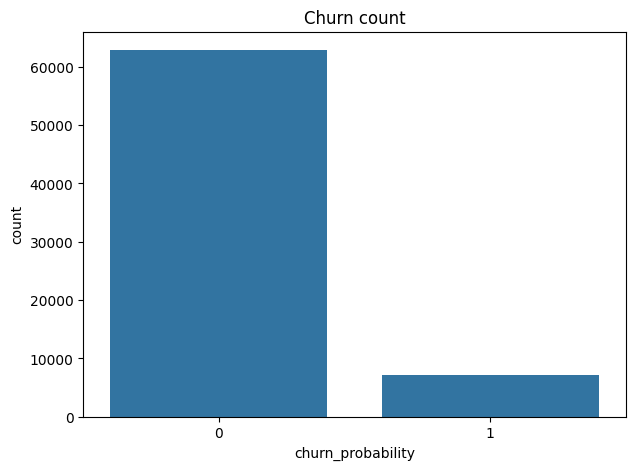

In [18]:
# Plot the Churn count
plt.figure(figsize=(7,5))
sns.countplot(x = 'churn_probability', data = train_data)
plt.title("Churn count")
plt.show()

Observation - Data is heavily missclassified. churning customer data is very less compared to non-churning data

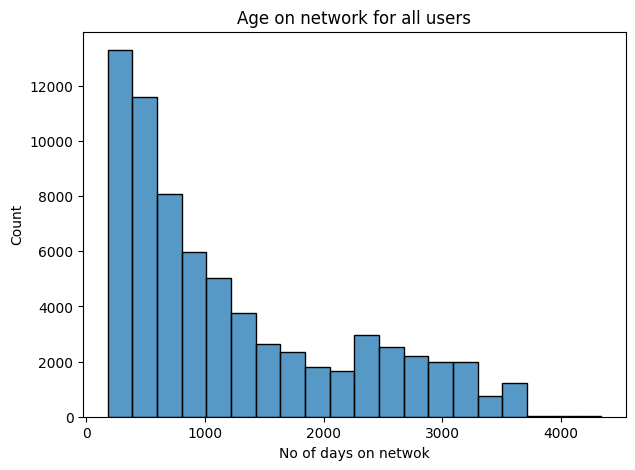

In [19]:
# Plot Histogram for Age on network for customers
plt.figure(figsize=(7,5))
# Get the value counts for age on network on customers (number of days the customer is using the operator T network)
sns.histplot(data=train_data, x='aon',bins=20)

plt.title('Age on network for all users')
plt.ylabel('Count')
plt.xlabel('No of days on netwok')

plt.show()

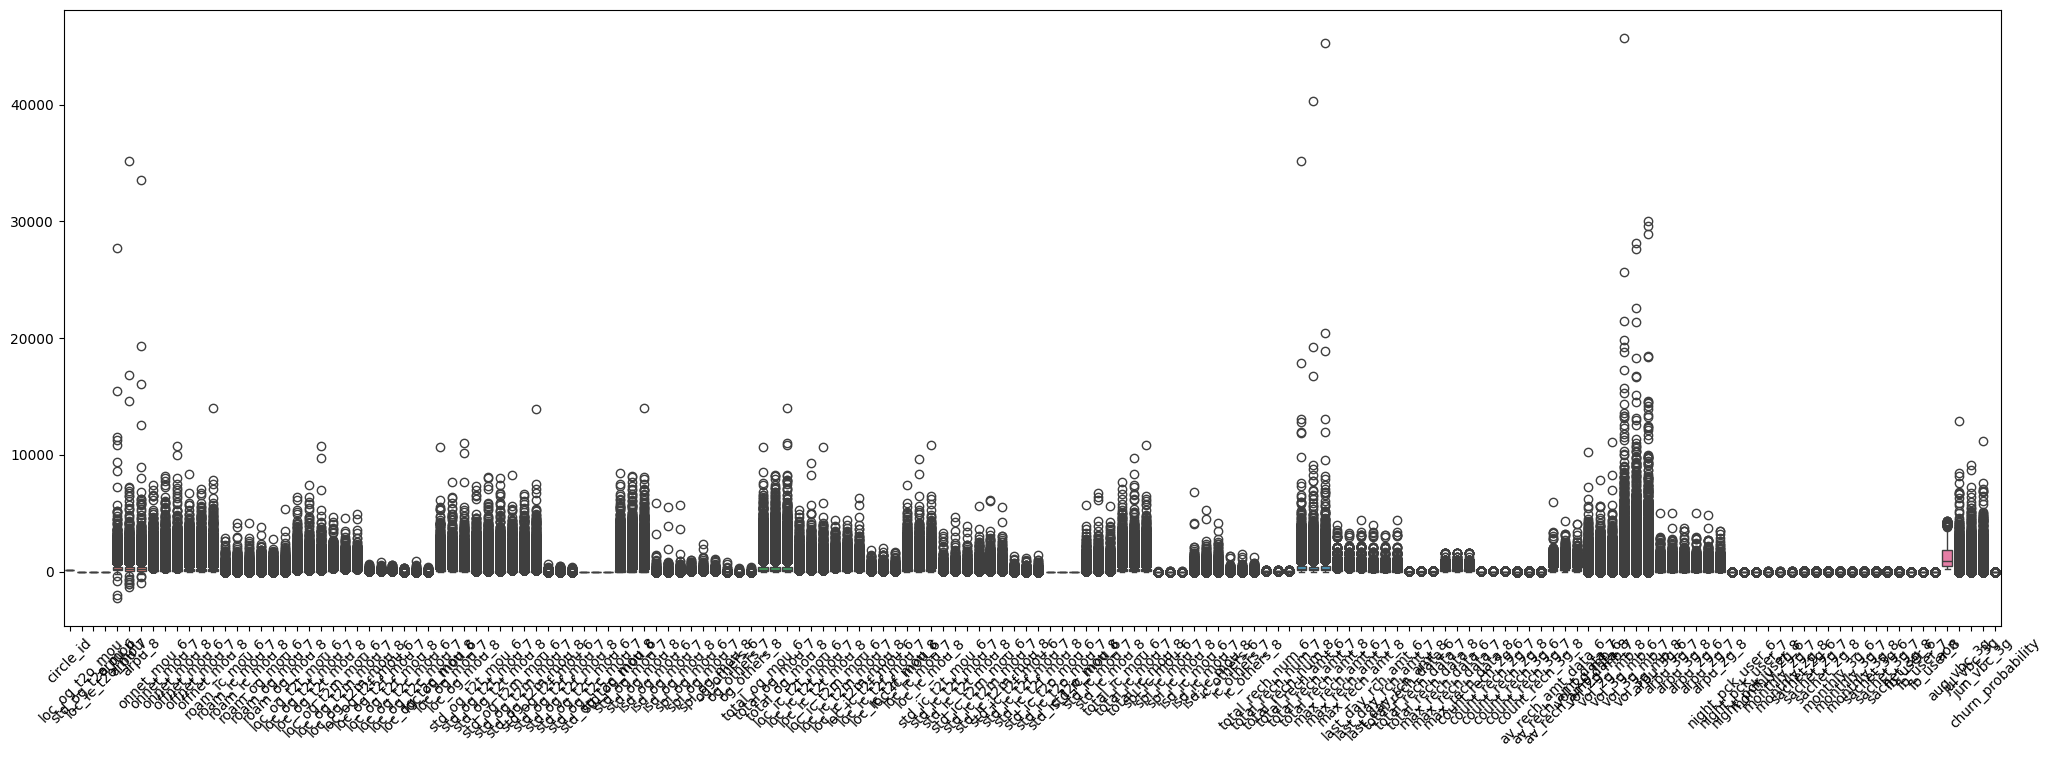

In [20]:
# plotting boxplot for variables in the data
plt.figure(figsize=(25,8))
plt.xticks(rotation=45)
sns.boxplot(data = train_data)
plt.show()

Observation -  The box plot shows there are lot of outliers in the data. These need to be handled

In [21]:
# Function definition for k-sigma method for capping outliers
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [22]:
train_data = train_data.apply(cap_outliers, axis=0)

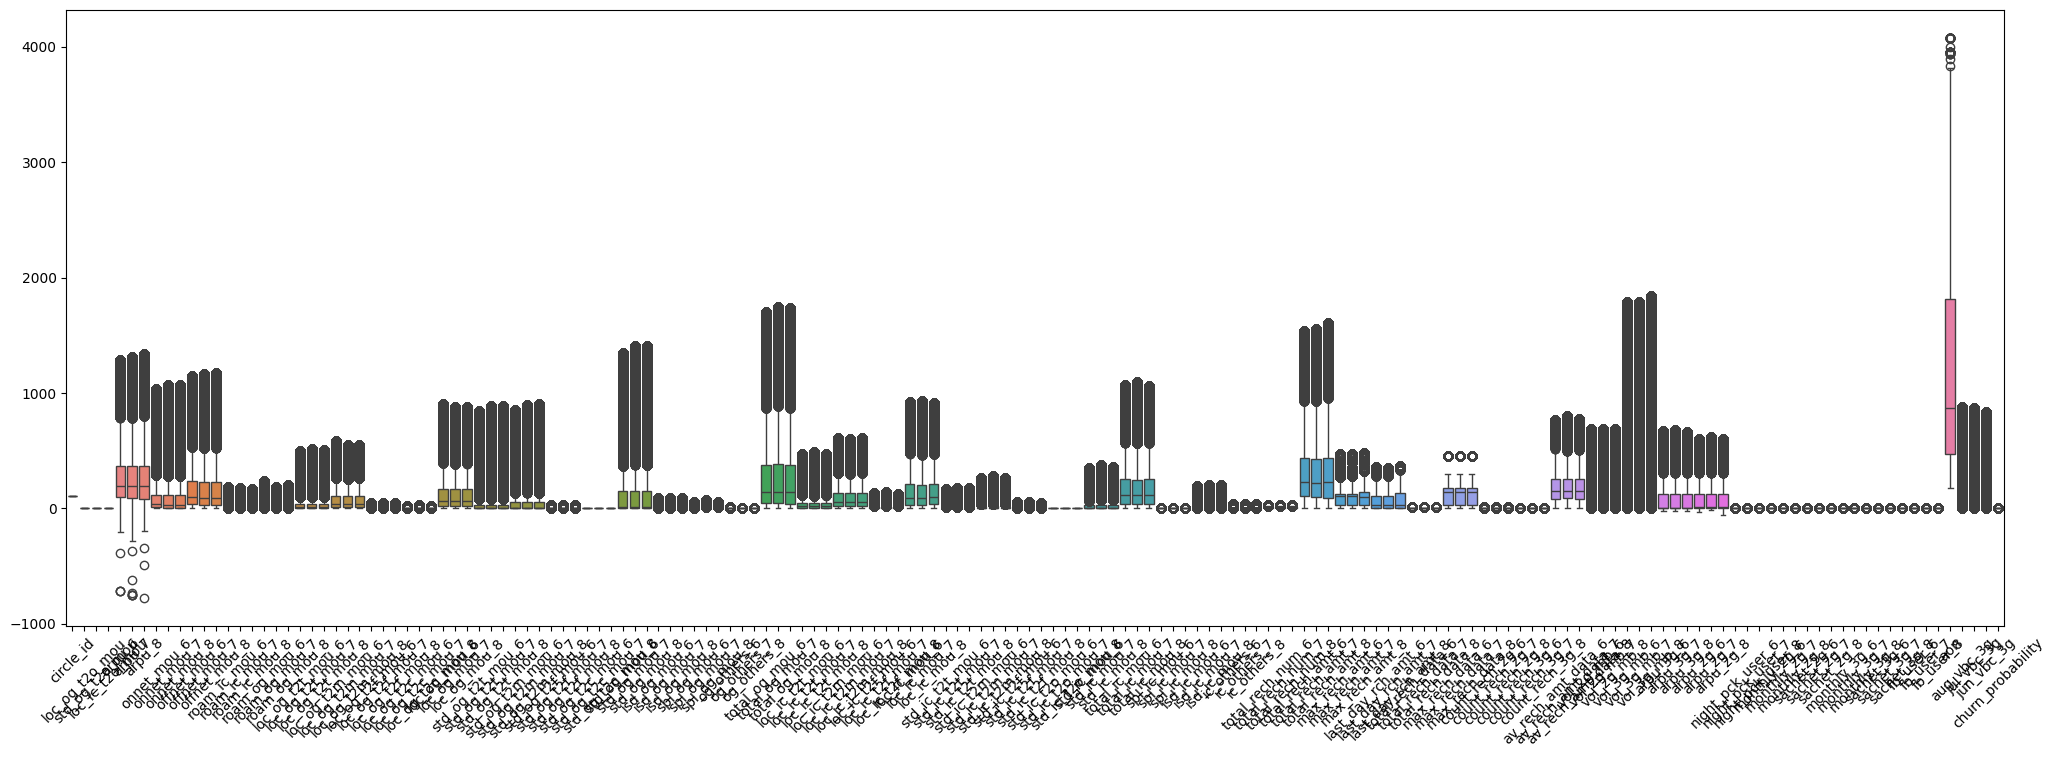

In [23]:
plt.figure(figsize=(25,8))
plt.xticks(rotation=45)
sns.boxplot(data = train_data)
plt.show()

#### Plot correlation matrix

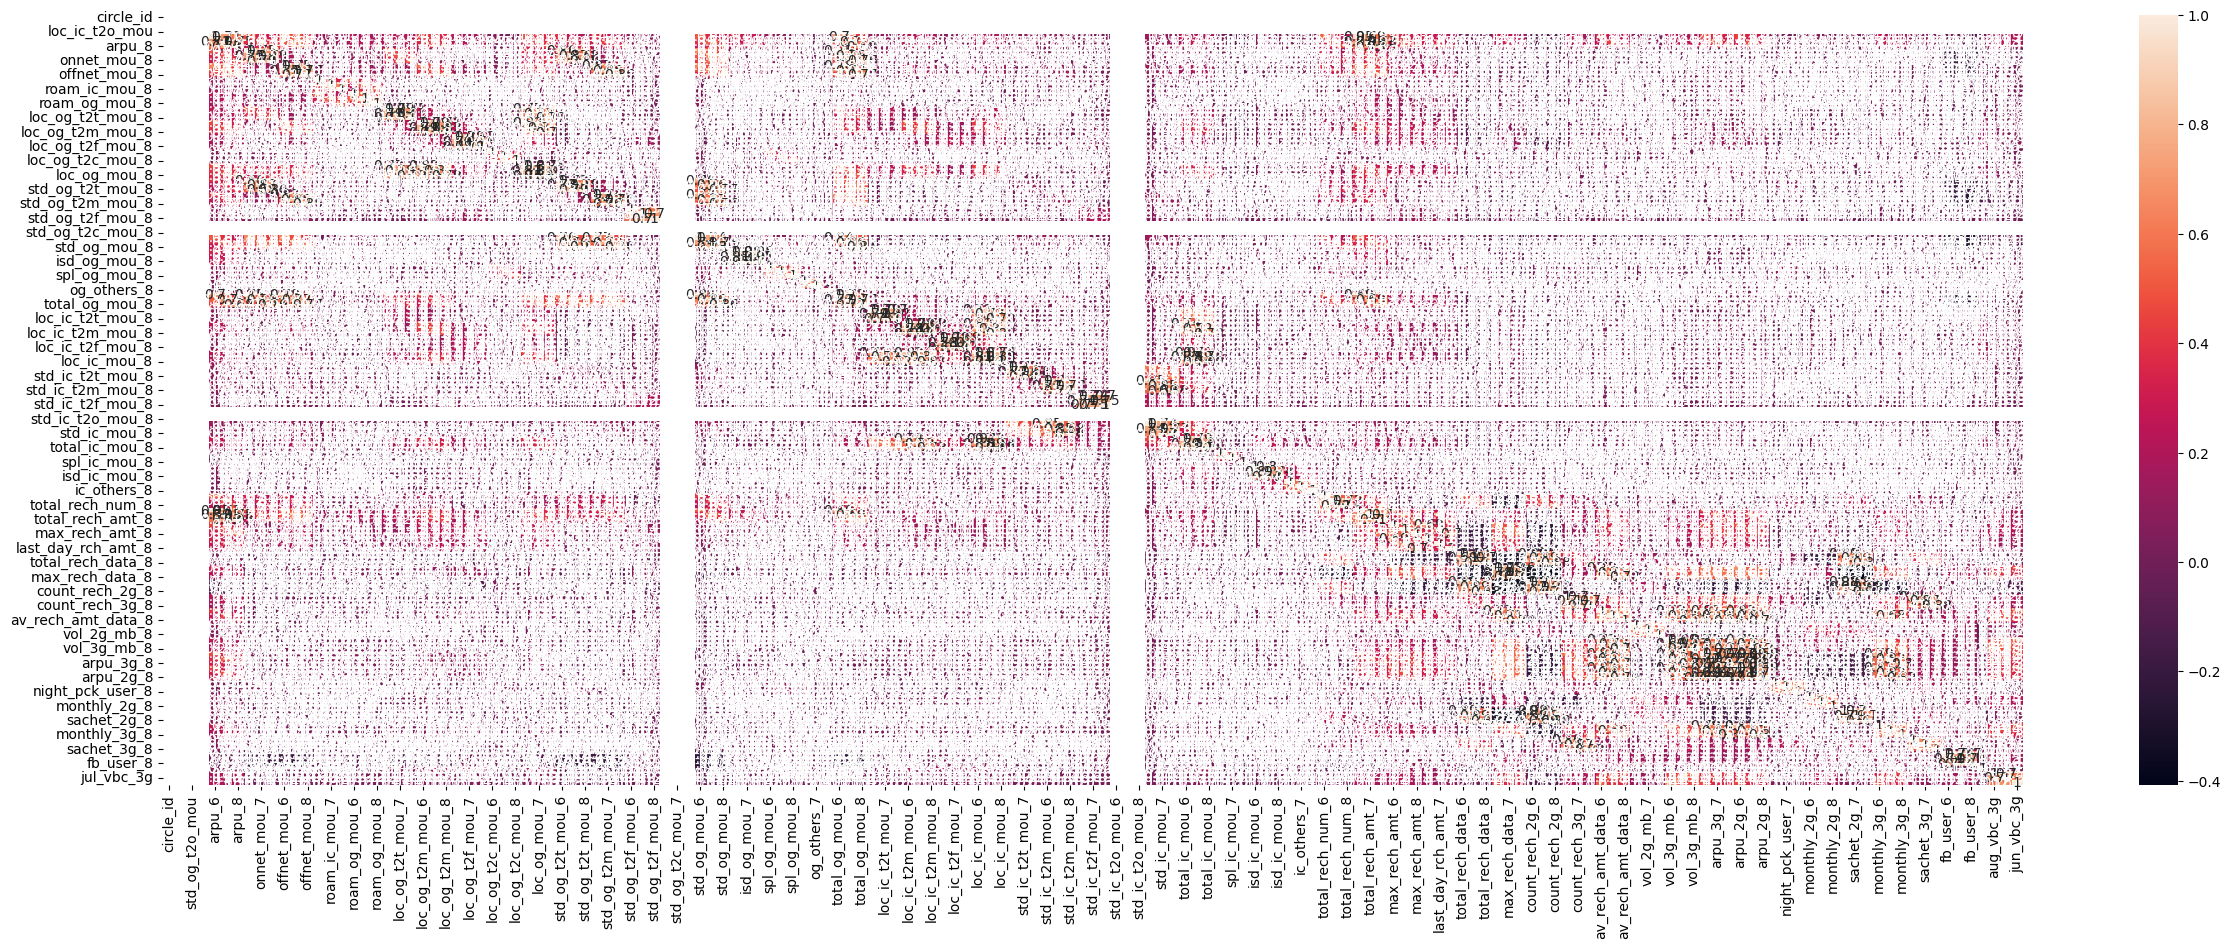

In [24]:
# Let's see the correlation matrix
plt.figure(figsize = (30,10))        # Size of the figure
sns.heatmap(X_train.corr(numeric_only=True),annot = True)
plt.show()

### 6. Building the Pipeline and Model - XGBoost

In [25]:
# Define the parameter grid
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

In [38]:
# Step 5: Train model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('pca', PCA(n_components=0.95)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method = "hist", device = "cuda"))
])

# Check column consistency before fitting
if set(valid_numeric_cols) != set(X_train.columns):
    raise ValueError("Mismatch between preprocessing pipeline columns and dataset columns.")


In [39]:
# Set up the random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='precision',  # You can choose other metrics like 'precision', 'recall', etc.
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [40]:
# Train the model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['circle_id',
                                                                                'loc_og_t2o_mou',
                                                                                'std_og_t2o_mou',
                                                                                'loc_ic_t2o_mou',
                                                                                'arpu_6',
                                                                                'arpu_7',
                                                                                'arpu_8',
                                                                                'onnet_mou_6',
                                                                                'onnet_mou_7',
                                                                                'onnet_mou_8',
                                                                                'offnet_mou_6',
                                                                                'offne...
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'classifier__colsample_bytree': [0.6,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__gamma': [0, 0.1, 0.2],
                                        'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__subsample': [0.6, 0.8,
                                                                  1.0]},
                   random_state=42, scoring='precision', verbose=1)

### 7. Evaluating the Model

In [41]:
# Evaluate the model
y_pred = random_search.predict(X_val)
y_pred_proba = random_search.predict_proba(X_val)[:, 1]

In [42]:
print("Model Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.5f}")
print(f"Precision: {precision_score(y_val, y_pred):.5f}")
print(f"Recall: {recall_score(y_val, y_pred):.5f}")
print(f"F1 Score: {f1_score(y_val, y_pred):.5f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_pred_proba):.5f}")

Model Performance:
Accuracy: 0.93207
Precision: 0.85736
Recall: 0.39733
F1 Score: 0.54301
ROC AUC: 0.93200


### Finding the Features affecting the Churn

In [43]:
best_model = random_search.best_estimator_
feature_importances = best_model.named_steps['classifier'].feature_importances_

print(f"Number of features: {len(X.columns)}")
print(f"Number of importances: {len(feature_importances)}")

important_features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Important Features:")
print(important_features.head(10))

Number of features: 161
Number of importances: 161

Top 10 Important Features:
              Feature  Importance
90     total_ic_mou_8    0.235107
60     total_og_mou_8    0.205205
6              arpu_8    0.080334
108    max_rech_amt_8    0.065133
24   loc_og_t2m_mou_8    0.028152
105  total_rech_amt_8    0.026226
9         onnet_mou_8    0.025251
12       offnet_mou_8    0.024684
18      roam_og_mou_8    0.023506
129       vol_2g_mb_8    0.023464


#### The above features are what is causing the customer to churn, So the company needs to focus on these features to retain the customers

### 8. Predicting on Unseen Data

In [44]:
import pandas as pd

# Make predictions on the test data
test_predictions = random_search.predict(test_data)

# Assuming the sample.csv contains columns 'id' and 'churn_probability'
# Merge the predictions with the sample data on 'id'
results_df = pd.DataFrame({
    'id': test_data['id'],
    'predicted_churn': test_predictions
})

# Merge with sample_df to compare predictions
comparison_df = pd.merge(sample_df, results_df, on='id')

# Calculate accuracy
# Assuming churn_probability in sample.csv is binary (0 or 1)
accuracy = accuracy_score(comparison_df['churn_probability'], comparison_df['predicted_churn'])

print(f"Model Accuracy on Test Data: {accuracy:.5f}")

Model Accuracy on Test Data: 0.95223


### 9. Save predictions to a CSV

In [46]:
output = pd.DataFrame({'id': test_data['id'], 'churn_probability': test_predictions})
output.to_csv('Submission.csv', index=False)